In [1]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import numpy as np
from tqdm import tqdm
import seaborn as sns

In [11]:
researchers = pd.read_pickle("Files/Dataframes/researchers.pkl") 
sponsUnitResearchers = pd.read_pickle("Files/Dataframes/researchers_sponsoringUnits.pkl")

In [10]:
divisionResearchers = researcher_positiveSeniority.drop_duplicates(subset = ['SearchName', 'Year', 'AssignedSponsoringUnit', 'SessionType']) #unique researchers, also wrt. sponsoring unit

NameError: name 'researcher_positiveSeniority' is not defined

In [ ]:
sponsoring unit

Attendees: potentially invited speakers

Find researchers similar to invited speakers.

use also field

try different distance measures

only compare researchers for same year, but do it for all years. Do it inside algorithm.

In [3]:
def standardizeColumn(df, columnName):
    standardizedColumn = (df[columnName] - df[columnName].mean())/(df[columnName].std())
    
    return standardizedColumn

In [4]:
#def KNN(df, features):
    #standardize column and create new df with the standardized attributes
#    KNN_researchers = df.copy()
#    for c in features:
#        KNN_researchers[c] = standardizeColumn(KNN_researchers, c)
    #invitedMales = KNN_researchers[(KNN_researchers.SessionType == 'invited') & (KNN_researchers.Gender == 'Male')]
#    invitedSpeakers = KNN_researchers[KNN_researchers.SessionType == 'invited'] #invited speakers
#    for i in invitedSpeakers.index: #loop through index
#        currentResearcher = invitedMales[invitedMales.index == i]
        #[features] #current researcher
#        year = currentResearcher.Year[i]
        #others that year
        #others = KNN_researchers[KNN_researchers.Year == year][['Seniority', 'CumulativePaperCount', 'Productivity']] #all that is not the current researcher
        
        #now do KNN from code below
#    return others

In [5]:
def KNN(df, features, K): #K for number of neighbors to find in KNN
    #standardize column and create new df with the standardized attributes
    KNN_dict = {}
    KNN_researchers = df.copy()
    for c in features:
        KNN_researchers[c] = standardizeColumn(KNN_researchers, c)
    #invitedMales = KNN_researchers[(KNN_researchers.SessionType == 'invited') & (KNN_researchers.Gender == 'Male')]
    invitedSpeakers = KNN_researchers[KNN_researchers.SessionType == 'invited'] #invited speakers
    for i in tqdm(invitedSpeakers.index): #loop through index of invited speakers
        currentInvited = invitedSpeakers[invitedSpeakers.index == i] #current invited speaker
        currentInvited_name = currentInvited.Name[i]        
        year = currentInvited.Year[i] #find year of current invited speaker
        yearResearchers = KNN_researchers[KNN_researchers.Year == year] #find researchers within "current" year
        other = yearResearchers[yearResearchers.SearchName != currentInvited_name] #remove current researcher
        #do KNN
        K = len(other) #when all neighbors should be found
        neighbors = NearestNeighbors(n_neighbors=K).fit(other[features])
        kNeighbor_dist, kNeighbor_ind = neighbors.kneighbors(currentInvited[features])
        KNN_dict[i] = {'Name': currentInvited_name, 'Year': year, 'Neighbor index': kNeighbor_ind[0], 'Neighbor distance': kNeighbor_dist[0]}
    return KNN_dict
    #return yearResearchers

In [6]:
KNN_dict = KNN(researchers, ['Seniority', 'CumulativePaperCount', 'Productivity'], 10)

100%|█████████████████████████████████████| 12725/12725 [02:09<00:00, 98.26it/s]


In [7]:
KNN_df = pd.DataFrame.from_dict(KNN_dict, orient='index').explode(['Neighbor index', 'Neighbor distance'])

In [13]:
KNN_df

,Name,Year,Neighbor index,Neighbor distance
2,Holger Waalkens,2009,0,0.0
2,Holger Waalkens,2009,4957,0.0
2,Holger Waalkens,2009,5050,0.0
2,Holger Waalkens,2009,3263,0.0
2,Holger Waalkens,2009,5067,0.0
...,...,...,...,...
554132,Jacinta Conrad,2016,4184,12.432312
554132,Jacinta Conrad,2016,11845,13.772413
554132,Jacinta Conrad,2016,10786,13.772413
554132,Jacinta Conrad,2016,7518,14.463688


KeyboardInterrupt: 

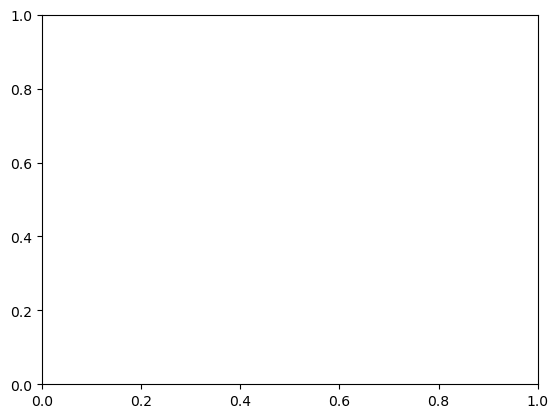

In [20]:
sns.histplot(data = KNN_df, x = 'Neighbor distance', bins = 10)

In [8]:
distance_table = KNN_df.groupby('Neighbor distance').count()

In [9]:
distanceCount = distance_table.reset_index()
distanceCount

,Neighbor distance,Name,Year,Neighbor index
0,0.000000e+00,372339,372339,372339
1,9.313226e-10,7,7,7
2,1.317089e-09,9,9,9
3,1.862645e-09,28,28,28
4,2.634178e-09,73,73,73
...,...,...,...,...
21395540,4.975554e+01,1,1,1
21395541,4.984776e+01,1,1,1
21395542,4.996473e+01,1,1,1
21395543,5.006720e+01,1,1,1


In [19]:
researchers.drop_duplicates(subset = ['Seniority', 'CumulativePaperCount', 'Productivity'])[['Seniority', 'CumulativePaperCount', 'Productivity']].max()

Seniority               218.000000
CumulativePaperCount    500.000000
Productivity            164.666667
dtype: float64

In [21]:
researchers[researchers.Seniority >= 100]

,SearchName,FirstName,ResearcherCount,MaxPaperCount,API_Field,API_FieldCount,ExternalField,ModelField,ExternalFieldCount,ModelFieldCount,...,Title,SponsoringUnit,SessionIndex,SessionType,Seniority,CumulativePaperCount,Productivity,firstName,Gender,AssignedSponsoringUnit
347,felix krueger,felix,12,33,Philosophy,7,Philosophy,History,7,1,...,Inference of emergent spatio-temporal processe...,DBIO,127935.0,attendee,120,19,0.158333,felix,Male,Biological Physics
651,pablo iglesias,pablo,107,6,Engineering,2,Engineering,Engineering,2,1,...,A modular view of directed cell migration,DCMP GSNP,128469.0,invited,120,1,0.008333,pablo,Male,None
855,hisao kanda,hisao,5,210,Materials Science,112,Materials Science,Materials Science,112,193,...,Pressure dependence of the first-order Raman f...,DCMP DMP,11195.0,attendee,100,166,1.660000,hisao,Male,None
1834,crispin contreras-martinez,crispin,2,22,Physics,13,Physics,Physics,13,21,...,Characterization of losses in dielectric subst...,DQI,11247.0,attendee,123,17,0.138211,crispin,Male,Quantum Information
1835,yuriy pischalnikov,yuriy,5,199,Physics,129,Physics,Physics,129,190,...,Characterization of losses in dielectric subst...,DQI,11247.0,attendee,123,189,1.536585,yuriy,Male,Quantum Information
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553732,pascoal pagliuso,pascoal,4,342,Physics,170,Physics,Physics,170,330,...,Structural and Physical Properties of CeAu2Bi:...,DCMP,135588.0,attendee,119,299,2.512605,pascoal,Male,Condensed Matter Physics
553733,pascoal pagliuso,pascoal,4,342,Physics,170,Physics,Physics,170,330,...,The Role of the Relaxation Rate of Nematic Flu...,DMP,142351.0,attendee,118,286,2.423729,pascoal,Male,Materials Physics
553735,pascoal pagliuso,pascoal,4,342,Physics,170,Physics,Physics,170,330,...,Complex magnetism in novel intermetallic compo...,DCMP,170995.0,attendee,123,336,2.731707,pascoal,Male,Condensed Matter Physics
553934,james martin,james,1275,3,Medicine,2,Medicine,Medicine,2,3,...,Dynamics of particle suspensions subjected to ...,DCMP,80671.0,invited,109,3,0.027523,james,Male,Condensed Matter Physics


In [ ]:
sns.barplot(data = distanceCount, x = 'Neighbor distance', y = 'Name')

In [ ]:
#now plot the distances from KNN_dict.
#Find a way to also check for individual distances. How much do they vary(variance)?
#Find a way to check for differences in differen years. Maybe a histogram for each year, or do year as hue

In [92]:
neighbors = NearestNeighbors(n_neighbors=10, metric = 'euclidean')
neighbors.fit(data)

knn = neighbors.kneighbors(researcher.reshape(1, -1))

NameError: name 'data' is not defined

In [91]:
test_df[['Seniority', 'CumulativePaperCount', 'Productivity']]

,Seniority,CumulativePaperCount,Productivity
2,2,2,1.000000
8,16,4,0.250000
111,43,104,2.418605
262,6,4,0.666667
264,2,1,0.500000
...,...,...,...
553878,25,15,0.600000
553921,37,20,0.540541
554146,15,46,3.066667
554174,7,3,0.428571


In [105]:
data = KNN_researchers[['Seniority', 'CumulativePaperCount', 'Productivity']]
researcher = KNN_researchers[KNN_researchers.SessionType == 'invited'][['Seniority', 'CumulativePaperCount', 'Productivity']].iloc[0].to_numpy().reshape(1, -1)

In [128]:
neighbors = NearestNeighbors(n_neighbors=10, metric = 'manhattan')
neighbors.fit(data)

NearestNeighbors(metric='manhattan', n_neighbors=10)

In [129]:
knn = neighbors.kneighbors(researcher.reshape(1, -1))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [130]:
knn

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[3406, 3583, 2282, 3576, 3464, 3473,    2,  135,  305,   52]]))

In [131]:
researcher

array([[-0.88210549, -0.51229433, -0.3393391 ]])

In [109]:
KNN_researchers.iloc[3406]

SearchName                                                         steve barr
FirstName                                                               steve
ResearcherCount                                                            11
MaxPaperCount                                                               2
API_Field                                               Environmental Science
API_FieldCount                                                              1
ExternalField                                           Environmental Science
ModelField                                              Environmental Science
ExternalFieldCount                                                          1
ModelFieldCount                                                             2
FirstPaperYear                                                           2008
Year                                                                     2010
Name                                                            

NearestNeighbors(n_neighbors=10)

In [80]:
knn = NearestNeighbors(n_neighbors=10, algorithm='auto')
knn.fit(KNN_researchers[['Seniority', 'CumulativePaperCount', 'Productivity']].to_numpy())

NearestNeighbors(n_neighbors=10)

In [ ]:
##do knn with one invited male speaker(for one year)


X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
>>> nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
>>> distances, indices = nbrs.kneighbors(X)